In [22]:
import pandas as pd
import csv
# from ibm_watson import ToneAnalyzerV3
# from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import numpy as np
import time
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

In [21]:
!pip install wordcloud

In [9]:
headers = ["timestamp","level","country","is_online",
           "first_survey","agree","primary_mode","preferred_mode",
           "why_mode","platforms_used","methods_used",
           "techniques_outside","remote_enjoy","remote_motivated",
           "remote_satisfied","remote_engaging","remote_distracted",
           "remote_questions","remote_changes","prior_enjoy",
           "prior_motivated","prior_satisfied","prior_engaging",
           "prior_distracted","prior_questions","prior_changes",
           "preference","why_preference"]

# Read in the raw data
full_data = pd.read_csv("raw_data.csv", skiprows=[0], names=headers, na_values="?")
remote_survey_q = ["remote_enjoy","remote_motivated",
                   "remote_satisfied","remote_engaging",
                   "remote_distracted","remote_questions"]
change_survey_q = ["change_enjoy","change_motivated",
                   "change_satisfied","change_engaging",
                   "change_distracted","change_questions"]
data = full_data.drop(["timestamp","first_survey","agree"], axis=1)
likert_dict = {"Strongly Disagree": 1, "Disagree": 2, "Neutral": 3, 
               "Agree": 4, "Strongly Agree": 5}
likert_code = {"remote_enjoy":       likert_dict,
               "remote_motivated":   likert_dict,
               "remote_satisfied":   likert_dict,
               "remote_engaging":    likert_dict,
               "remote_distracted":  likert_dict,
               "remote_questions":   likert_dict,
               "prior_enjoy":       likert_dict,
               "prior_motivated":   likert_dict,
               "prior_satisfied":   likert_dict,
               "prior_engaging":    likert_dict,
               "prior_distracted":  likert_dict,
               "prior_questions":   likert_dict}
data.replace(likert_code, inplace=True)
modes = {"primary_mode":   {"Live classes (ie: Zoom, Google Meet etc.)": "live",
                            "Uploaded or emailed Materials": "upload",
                            "Recorded Lectures": "recorded",
                            "Discussion forums/chats": "chat"},
         "preferred_mode":   {"Live classes (ie: Zoom, google meet etc.)": "live",
                            "Uploaded or emailed Materials": "upload",
                            "Recorded Lectures/Videos": "recorded",
                            "Discussion forums/chats": "chat"}}

data.replace(modes, inplace=True)


In [10]:
duplicate = data[data.duplicated()]
print('# of duplicates: ', len(duplicate))
print('Valid entries: ', duplicate[duplicate['primary_mode'].isna()==False].index)
print('# of duplicates for valid entries: ', len(duplicate[duplicate['primary_mode'].isna()==False].index))
print('NaN entries: ', duplicate[duplicate['primary_mode'].isna()].index)
print('# of duplicates for NaN entries: ', len(duplicate[duplicate['primary_mode'].isna()]))
data = data.drop(duplicate.index, axis=0)
data.shape

# of duplicates:  81
Valid entries:  Int64Index([1143, 1892, 2196, 3446, 4567, 4812, 4822, 4873, 5218, 5219, 5449,
            6093, 6996, 7053, 7836, 7868, 8129, 8154, 8213],
           dtype='int64')
# of duplicates for valid entries:  19
NaN entries:  Int64Index([  20,   56,  124,  208,  322,  416,  431,  587,  773,  995, 1018,
            1027, 1419, 1500, 1534, 1682, 1695, 1712, 1832, 2069, 2144, 2205,
            2896, 2983, 3225, 3590, 3622, 3674, 3749, 3837, 3908, 4065, 4098,
            4253, 4258, 4354, 5178, 5403, 5542, 5668, 5719, 5762, 5827, 5942,
            6026, 6143, 6211, 6719, 6745, 6781, 6809, 6941, 6973, 7161, 7471,
            7482, 7530, 7654, 7746, 7833, 8128, 8150],
           dtype='int64')
# of duplicates for NaN entries:  62


(8162, 25)

In [11]:
qualitative_data = data.loc[:,['preferred_mode','why_mode', 'preference', 'why_preference', 'remote_changes', 'prior_changes']]
# qualitative_data['mode_tone'] = np.zeros((data.shape[0], 1))
# qualitative_data['preference_tone'] = np.zeros((data.shape[0], 1))
# qualitative_data['remote_changes_tone'] = np.zeros((data.shape[0], 1))
# qualitative_data['prior_changes_tone'] = np.zeros((data.shape[0], 1))

In [14]:
nlp = spacy.load('en')
def tokenize(text):
  ls = []
  if not pd.isna(text):
    tokens = nlp(text)
    for token in tokens:
      if not token.is_stop and not token.is_punct:
        ls.append(str(token.lemma_).lower())
  return ls
tokenize('I am loving a very nice talk.')

['love', 'nice', 'talk']

In [28]:
def word_cloud(data, col):
  start = time.time()
  token = data[col].apply(tokenize)
  token_string = []
  for idx, row in token.iteritems():
    token_string.extend(row)
  freq = pd.Series(token_string).rename('token_freq').value_counts(normalize=True)
  token_string = ' '.join(token_string)
  wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_string)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show()
  end = time.time()
  return end-start, freq

0                   [interactive, ask, help, easily, etc]
1                                      [face, face, feel]
2                                    [pause, learn, pace]
3                                                 [chill]
4                                    [easy, follow, look]
                              ...                        
8238    [obviously, perfect, give, chance, stop, teach...
8239    [adjust, speed, lecture, optimize, study, time...
8240                          [slow, internet, connexion]
8241    [slow, internet, zoom, lecture, convenient, ti...
8242                                                   []
Name: why_mode, Length: 8162, dtype: object


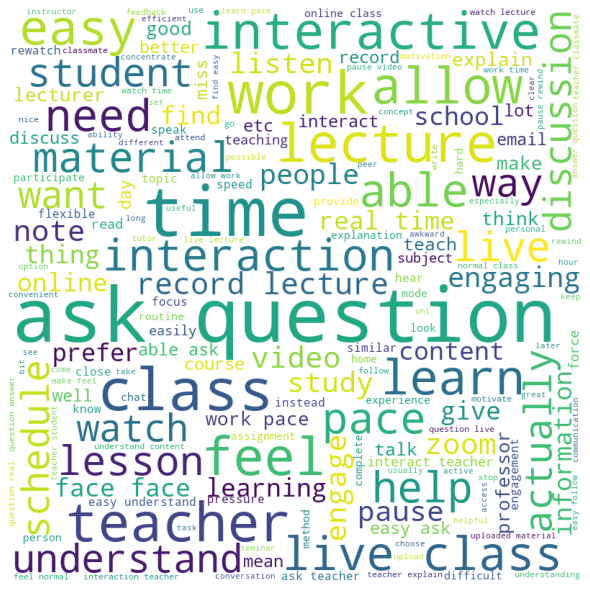

75.26940107345581 time            0.028196
question        0.026037
class           0.023667
ask             0.023185
teacher         0.019600
                  ...   
paperwork       0.000019
explenation     0.000019
extract         0.000019
rant            0.000019
interactive/    0.000019
Name: token_freq, Length: 2938, dtype: float64


In [29]:
duration_mode, freq_mode = word_cloud(qualitative_data, 'why_mode')
print(duration_mode, freq_mode)

0       [easy, ask, help, easy, understand, content, i...
1       [person, feel, subject, relate, aswell, help, ...
2                                [motivate, work, person]
3                                                [friend]
4                                          [easy, debate]
                              ...                        
8238    [comfort, time, waste, transport, useless, stu...
8239    [online, class, opportunity, optimize, time, l...
8240           [waste, time, transportation, save, money]
8241                                           [engaging]
8242                                            [minerva]
Name: why_preference, Length: 8162, dtype: object


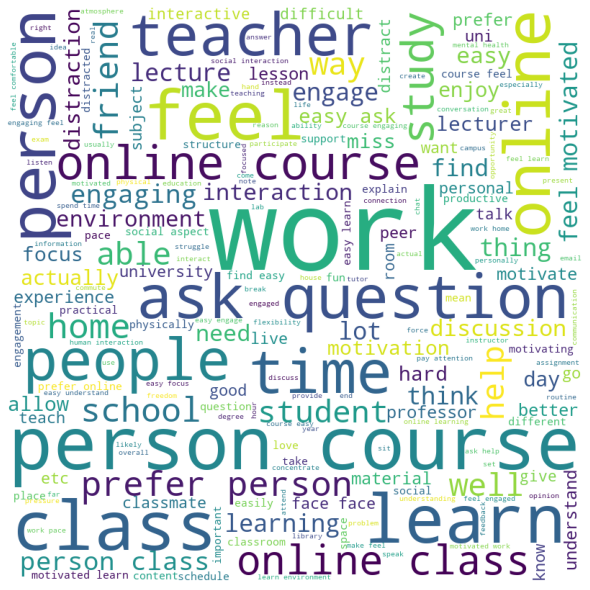

duration 88.61221575737
frequency person        0.035540
online        0.027040
course        0.023371
feel          0.023224
class         0.022686
                ...   
athlete       0.000012
tedious       0.000012
station       0.000012
chit          0.000012
incomplete    0.000012
Name: token_freq, Length: 4270, dtype: float64


In [30]:
duration_preference, freq_preference = word_cloud(qualitative_data, 'why_preference')
print('duration', duration_preference)
print('frequency', freq_preference)

0         [interactive, fun, eg, mini, group, discussion]
1                                                     [n]
2                                    [recorded, teaching]
3                                                      []
4                                          [live, debate]
                              ...                        
8238    [add, interactivity, person, course, include, ...
8239    [time, management, content, delivery, professo...
8240                                                   []
8241    [engaging, sure, upload, video, explain, lecture]
8242                                                   []
Name: remote_changes, Length: 8162, dtype: object


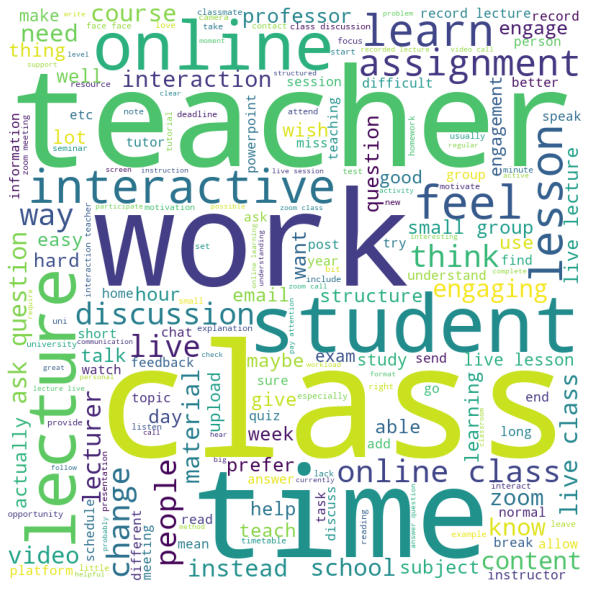

duration 81.7504494190216
frequency class       0.033999
teacher     0.021445
live        0.020053
work        0.017950
lecture     0.017719
              ...   
login       0.000015
embed       0.000015
videos      0.000015
lot(not     0.000015
changing    0.000015
Name: token_freq, Length: 4032, dtype: float64


In [31]:
duration_remote_change, freq_remote_change = word_cloud(qualitative_data, 'remote_changes')
print('duration', duration_remote_change)
print('frequency', freq_remote_change)

0                                  [quiz, progress, test]
1                                                     [n]
2                                                      []
3                                                      []
4                                                      []
                              ...                        
8238    [talk, project, practical, work, well, constan...
8239    [content, delivery, yearly, update, syllabus, ...
8240                                                   []
8241                                                   []
8242                                                   []
Name: prior_changes, Length: 8162, dtype: object


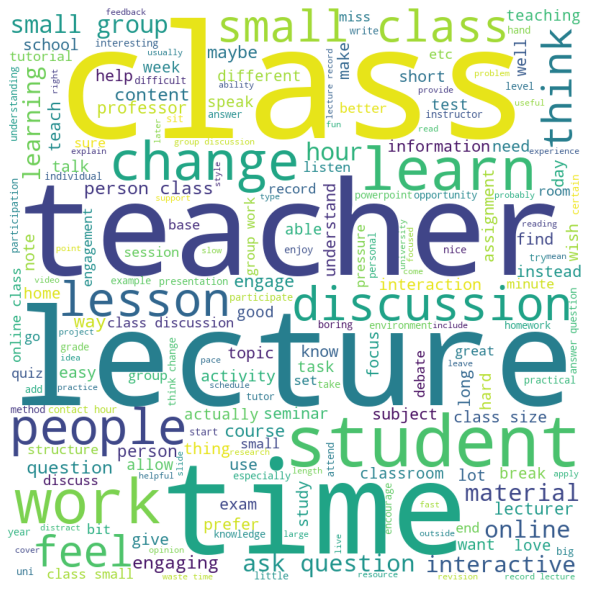

duration 53.900715589523315
frequency class          0.046540
lecture        0.020954
time           0.017830
teacher        0.016779
small          0.016672
                 ...   
voluntarily    0.000027
labs           0.000027
1.5hrs         0.000027
inclined       0.000027
connected      0.000027
Name: token_freq, Length: 3307, dtype: float64


In [32]:
duration_prior_change, freq_prior_change = word_cloud(qualitative_data, 'prior_changes')
print('duration', duration_prior_change)
print('frequency', freq_prior_change)